In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    print("X_train.shape[0] :")
    print(X_train.shape[0])
    
    # Creating GAN
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    
    ## structure of model
    from keras.utils import plot_model
    plot_model(generator, show_shapes=True, to_file='generator.png')
    
    plot_model(discriminator, show_shapes=True, to_file='discriminator.png')
    
    plot_model(gan, show_shapes=True, to_file='gan.png')
    
    for e in range(1,epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        # Generate random noise as an input to initialize the generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            #print(np.random.randint(low=0,high=X_train.shape[0],size=batch_size))
            
            #image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            image_batch =X_train[[23055, 28835, 54990, 7399, 27064, 2240, 23563, 20175, 48587, 23497, 30739, 19487, 10890, 7304, 4097, 5882, 21277, 18833, 15069, 41175, 44290, 29425, 36944, 4689, 6274, 47046, 18824, 793, 32613, 21991, 21225, 36754, 50260, 45716, 56500, 10304, 5818, 15503, 54888, 10237, 8694, 46770, 24051, 653, 19732, 12171, 47175, 56668, 20929, 2905, 51254, 41912, 42546, 26813, 48107, 3490, 46501, 22268, 16402, 23322, 33442, 11496, 43584, 41316, 2952, 34385, 3310, 58991, 29984, 3730, 15684, 32679, 28942, 59546, 20762, 51685, 21791, 45218, 12396, 17516, 15399, 1159, 5604, 6747, 57657, 45619, 773, 15324, 21367, 23697, 37598, 52411, 27027, 26084, 48443, 47842, 58265, 58137, 20165, 7991, 51826, 2159, 57884, 3078, 2084, 2778, 53902, 45571, 46595, 38783, 46354, 21060, 40002, 34092, 35543, 1729, 18621, 56078, 4960, 20655, 12971, 7312, 57736, 6510, 16614, 24894, 30897, 10702]]
            # Construct different batches of real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            # Pretrain discriminator on  fake and real data before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            # Tricking the noised input of the Generator as real data
            y_gen = np.ones(batch_size)
            
            # During the training of gan, the weights of discriminator should be fixed. 
            # We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            # Training  the GAN by alternating the training of the Discriminator and training the chained GAN model with Discriminator's weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)


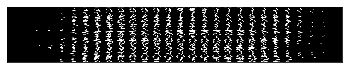

In [15]:
import conx as cx
batch_size = 128
(X_train, y_train, X_test, y_test) = load_data()
batch_count = X_train.shape[0] / batch_size
image_batch = X_train[[23055, 28835, 54990, 7399, 27064, 2240, 23563, 20175, 48587, 23497, 30739, 19487, 10890, 7304, 4097, 5882, 21277, 18833, 15069, 41175, 44290, 29425, 36944, 4689, 6274, 47046, 18824, 793, 32613, 21991, 21225, 36754, 50260, 45716, 56500, 10304, 5818, 15503, 54888, 10237, 8694, 46770, 24051, 653, 19732, 12171, 47175, 56668, 20929, 2905, 51254, 41912, 42546, 26813, 48107, 3490, 46501, 22268, 16402, 23322, 33442, 11496, 43584, 41316, 2952, 34385, 3310, 58991, 29984, 3730, 15684, 32679, 28942, 59546, 20762, 51685, 21791, 45218, 12396, 17516, 15399, 1159, 5604, 6747, 57657, 45619, 773, 15324, 21367, 23697, 37598, 52411, 27027, 26084, 48443, 47842, 58265, 58137, 20165, 7991, 51826, 2159, 57884, 3078, 2084, 2778, 53902, 45571, 46595, 38783, 46354, 21060, 40002, 34092, 35543, 1729, 18621, 56078, 4960, 20655, 12971, 7312, 57736, 6510, 16614, 24894, 30897, 10702]]
cx.view(image_batch)

X_train.shape[0] :
60000


  0%|                                                                                                 | 0/128 [00:00<?, ?it/s]

Epoch 1


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 2


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 3


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 4


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.27it/s]

Epoch 5


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 6


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 7


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 8


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 9


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.00it/s]

Epoch 10


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 11


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 12


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 13


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 14


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.94it/s]

Epoch 15


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 16


  4%|███▍                                                                                     | 5/128 [00:00<00:02, 46.76it/s]

Epoch 17


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 18


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 19


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 59.44it/s]

Epoch 20


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 21


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 22


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.94it/s]

Epoch 23


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 24


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 25


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 26


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.47it/s]

Epoch 27


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 28


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 29


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.28it/s]

Epoch 30


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 31


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 32


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 33


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.07it/s]

Epoch 34


  4%|███▍                                                                                     | 5/128 [00:00<00:02, 42.04it/s]

Epoch 35


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 36


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 37


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 38


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 39


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 40


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 41


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.10it/s]

Epoch 42


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.10it/s]

Epoch 43


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 55.59it/s]

Epoch 44


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 45


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 50.45it/s]

Epoch 46


  4%|███▍                                                                                     | 5/128 [00:00<00:03, 40.02it/s]

Epoch 47


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 48


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 57.73it/s]

Epoch 49


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 61.98it/s]

Epoch 50


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 51


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 52


  6%|█████▌                                                                                   | 8/128 [00:00<00:01, 70.22it/s]

Epoch 53


  5%|████▊                                                                                    | 7/128 [00:00<00:02, 56.95it/s]

Epoch 54


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 55


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.40it/s]

Epoch 56


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 57


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.47it/s]

Epoch 58


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 69.35it/s]

Epoch 59


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.36it/s]

Epoch 60


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 61


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 62


  2%|██                                                                                       | 3/128 [00:00<00:04, 26.33it/s]

Epoch 63


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.74it/s]

Epoch 64


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 65


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 69.35it/s]

Epoch 66


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 62.54it/s]

Epoch 67


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 53.13it/s]

Epoch 68


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.35it/s]

Epoch 69


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 70


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 71


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 72


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 73


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 74


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 75


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 57.73it/s]

Epoch 76


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 77


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 78


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 79


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 60.91it/s]

Epoch 80


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 81


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 82


  2%|██                                                                                       | 3/128 [00:00<00:04, 29.72it/s]

Epoch 83


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 84


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 85


  6%|█████▌                                                                                   | 8/128 [00:00<00:01, 70.22it/s]

Epoch 86


  5%|████▊                                                                                    | 7/128 [00:00<00:02, 60.38it/s]

Epoch 87


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 88


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 89


  5%|████▊                                                                                    | 7/128 [00:00<00:02, 59.87it/s]

Epoch 90


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 91


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 92


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 93


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 94


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 55.08it/s]

Epoch 95


  5%|████▊                                                                                    | 7/128 [00:00<00:02, 60.38it/s]

Epoch 96


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 97


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 98


  2%|██                                                                                       | 3/128 [00:00<00:04, 26.57it/s]

Epoch 99


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 100


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 101


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 53.60it/s]

Epoch 102


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 103


 10%|████████▉                                                                               | 13/128 [00:00<00:01, 61.33it/s]

Epoch 104


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 105


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 61.44it/s]

Epoch 106


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 107


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 108


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 52.21it/s]

Epoch 109


  4%|███▍                                                                                     | 5/128 [00:00<00:02, 46.76it/s]

Epoch 110


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 111


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 112


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 113


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.86it/s]

Epoch 114


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 115


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 116


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 117


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 118


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 119


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 120


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 121


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 122


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 123


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 124


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 125


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.86it/s]

Epoch 126


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 127


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 128


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.40it/s]

Epoch 129


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 69.35it/s]

Epoch 130


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 69.35it/s]

Epoch 131


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 132


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.67it/s]

Epoch 133


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.00it/s]

Epoch 134


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 66.84it/s]

Epoch 135


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 136


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 137


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.16it/s]

Epoch 138


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.87it/s]

Epoch 139


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 140


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 141


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 142


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 143


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 144


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 145


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.81it/s]

Epoch 146


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 147


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.81it/s]

Epoch 148


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 149


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 150


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.47it/s]

Epoch 151


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 152


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 66.90it/s]

Epoch 153


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.94it/s]

Epoch 154


  3%|██▊                                                                                      | 4/128 [00:00<00:03, 32.02it/s]

Epoch 155


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 62.54it/s]

Epoch 156


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 157


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 158


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 159


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 69.35it/s]

Epoch 160


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 161


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.20it/s]

Epoch 162


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 163


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 164


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 165


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 166


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 167


  6%|█████▌                                                                                   | 8/128 [00:00<00:01, 70.22it/s]

Epoch 168


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 169


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 170


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 54.58it/s]

Epoch 171


  6%|█████▌                                                                                   | 8/128 [00:00<00:01, 69.61it/s]

Epoch 172


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 173


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 174


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 175


  4%|███▍                                                                                     | 5/128 [00:00<00:02, 48.11it/s]

Epoch 176


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.74it/s]

Epoch 177


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 178


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 179


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 180


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 181


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 59.44it/s]

Epoch 182


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 57.73it/s]

Epoch 183


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 60.91it/s]

Epoch 184


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 185


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 186


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 187


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 188


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 61.99it/s]

Epoch 189


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 190


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 61.44it/s]

Epoch 191


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 59.44it/s]

Epoch 192


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 193


  6%|█████▌                                                                                   | 8/128 [00:00<00:01, 70.22it/s]

Epoch 194


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.81it/s]

Epoch 195


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 196


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 197


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 198


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 199


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 200


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 201


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 202


  3%|██▊                                                                                      | 4/128 [00:00<00:03, 31.77it/s]

Epoch 203


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 204


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 205


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 66.45it/s]

Epoch 206


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 207


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 208


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 57.18it/s]

Epoch 209


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 210


  6%|█████▌                                                                                   | 8/128 [00:00<00:01, 69.61it/s]

Epoch 211


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 212


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 213


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 214


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 60.91it/s]

Epoch 215


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 216


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 217


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.10it/s]

Epoch 218


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 219


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 220


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.10it/s]

Epoch 221


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 57.18it/s]

Epoch 222


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 223


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 224


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 225


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 226


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.35it/s]

Epoch 227


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 228


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.10it/s]

Epoch 229


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 230


  2%|██                                                                                       | 3/128 [00:00<00:05, 23.45it/s]

Epoch 231


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 232


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 61.99it/s]

Epoch 233


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 234


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.54it/s]

Epoch 235


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 236


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 66.27it/s]

Epoch 237


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 238


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 239


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 240


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 241


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.00it/s]

Epoch 242


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 243


  3%|██▊                                                                                      | 4/128 [00:00<00:03, 36.72it/s]

Epoch 244


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.94it/s]

Epoch 245


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 246


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.86it/s]

Epoch 247


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 248


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 249


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 250


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 251


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.00it/s]

Epoch 252


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 253


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 254


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.54it/s]

Epoch 255


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 256


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 257


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 258


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 259


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 260


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 261


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 262


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 54.09it/s]

Epoch 263


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 52.66it/s]

Epoch 264


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 265


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 266


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 267


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 268


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.00it/s]

Epoch 269


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 270


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 271


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 272


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 273


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 274


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 275


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 66.90it/s]

Epoch 276


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.61it/s]

Epoch 277


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 278


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 279


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 69.35it/s]

Epoch 280


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 281


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 282


  3%|██▊                                                                                      | 4/128 [00:00<00:03, 35.74it/s]

Epoch 283


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 65.58it/s]

Epoch 284


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 285


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 286


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 287


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 288


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 289


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 290


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 62.54it/s]

Epoch 291


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.35it/s]

Epoch 292


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 293


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 294


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 295


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 56.11it/s]

Epoch 296


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 297


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.16it/s]

Epoch 298


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 299


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 300


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 301


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 302


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 303


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.67it/s]

Epoch 304


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 66.90it/s]

Epoch 305


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 306


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.16it/s]

Epoch 307


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 308


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 309


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 310


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 311


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 312


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 313


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 314


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 315


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.86it/s]

Epoch 316


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 317


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 318


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 319


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 320


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 321


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 322


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 323


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 324


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 57.18it/s]

Epoch 325


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 55.59it/s]

Epoch 326


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 61.44it/s]

Epoch 327


  6%|█████▌                                                                                   | 8/128 [00:00<00:01, 69.61it/s]

Epoch 328


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 329


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 330


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 331


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 332


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 333


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.86it/s]

Epoch 334


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 335


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 336


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 62.54it/s]

Epoch 337


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 59.44it/s]

Epoch 338


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.29it/s]

Epoch 339


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 56.64it/s]

Epoch 340


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 341


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 342


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.10it/s]

Epoch 343


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.09it/s]

Epoch 344


  4%|███▍                                                                                     | 5/128 [00:00<00:02, 44.67it/s]

Epoch 345


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 346


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.86it/s]

Epoch 347


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 348


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 349


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 350


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 351


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 66.45it/s]

Epoch 352


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 68.00it/s]

Epoch 353


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 69.35it/s]

Epoch 354


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.54it/s]

Epoch 355


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 61.44it/s]

Epoch 356


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 357


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.87it/s]

Epoch 358


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 359


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 360


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 361


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 65.52it/s]

Epoch 362


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.00it/s]

Epoch 363


  6%|█████▌                                                                                   | 8/128 [00:00<00:01, 70.22it/s]

Epoch 364


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 365


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 366


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.71it/s]

Epoch 367


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 368


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 369


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 62.53it/s]

Epoch 370


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 371


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 372


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.10it/s]

Epoch 373


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.10it/s]

Epoch 374


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 375


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 68.33it/s]

Epoch 376


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 377


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.10it/s]

Epoch 378


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 379


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 63.68it/s]

Epoch 380


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 381


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 62.54it/s]

Epoch 382


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 55.08it/s]

Epoch 383


  6%|█████▌                                                                                   | 8/128 [00:00<00:01, 70.84it/s]

Epoch 384


  5%|████▊                                                                                    | 7/128 [00:00<00:02, 59.87it/s]

Epoch 385


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 67.35it/s]

Epoch 386


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 387


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 388


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 389


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 69.35it/s]

Epoch 390


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 65.46it/s]

Epoch 391


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 392


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 58.86it/s]

Epoch 393


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 61.98it/s]

Epoch 394


  5%|████▏                                                                                    | 6/128 [00:00<00:02, 53.13it/s]

Epoch 395


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.26it/s]

Epoch 396


 11%|█████████▋                                                                              | 14/128 [00:00<00:01, 67.16it/s]

Epoch 397


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 66.08it/s]

Epoch 398


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 399


  5%|████▊                                                                                    | 7/128 [00:00<00:01, 64.85it/s]

Epoch 400


100%|███████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 65.92it/s]
C:\ProgramData\Anaconda3\envs\pyksy\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


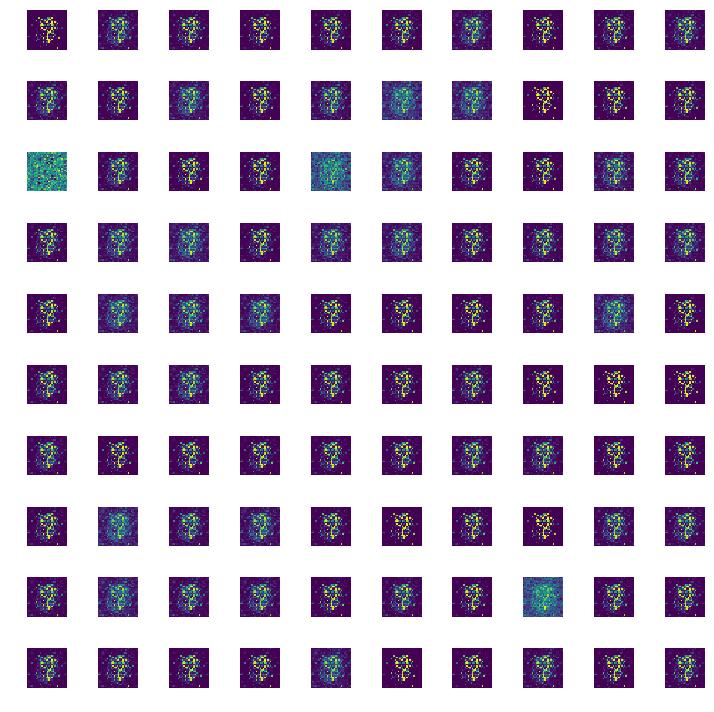

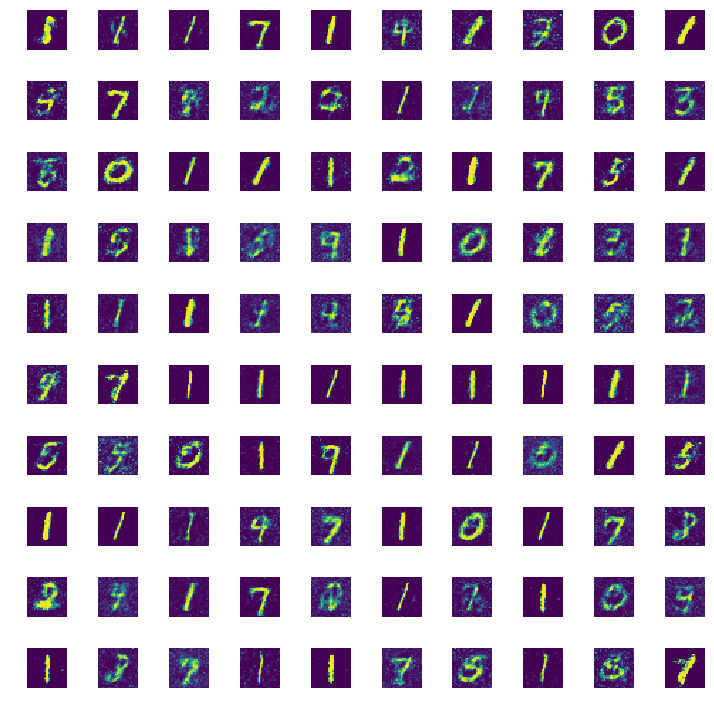

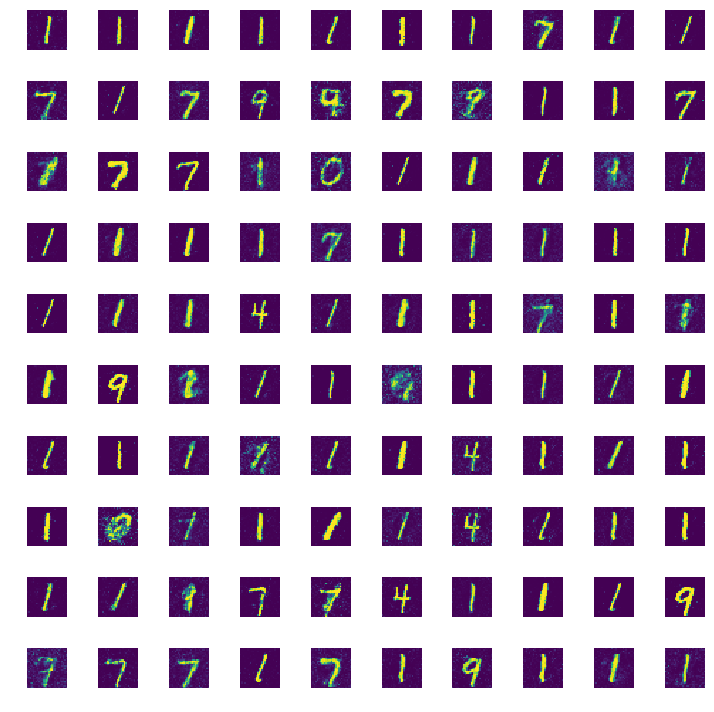

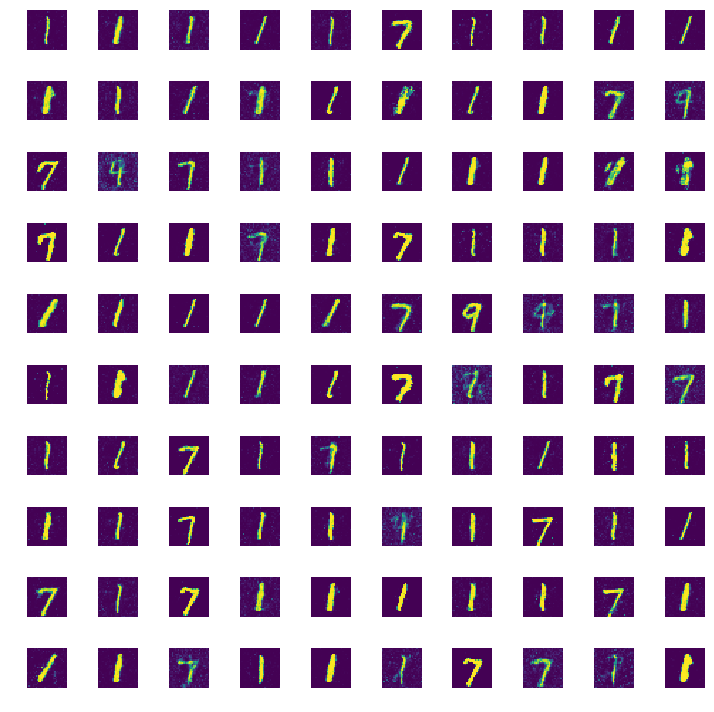

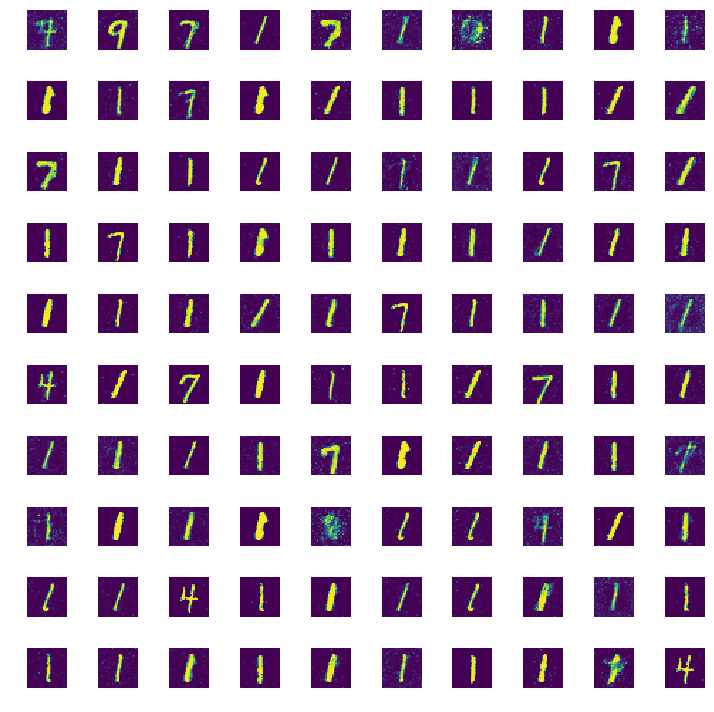

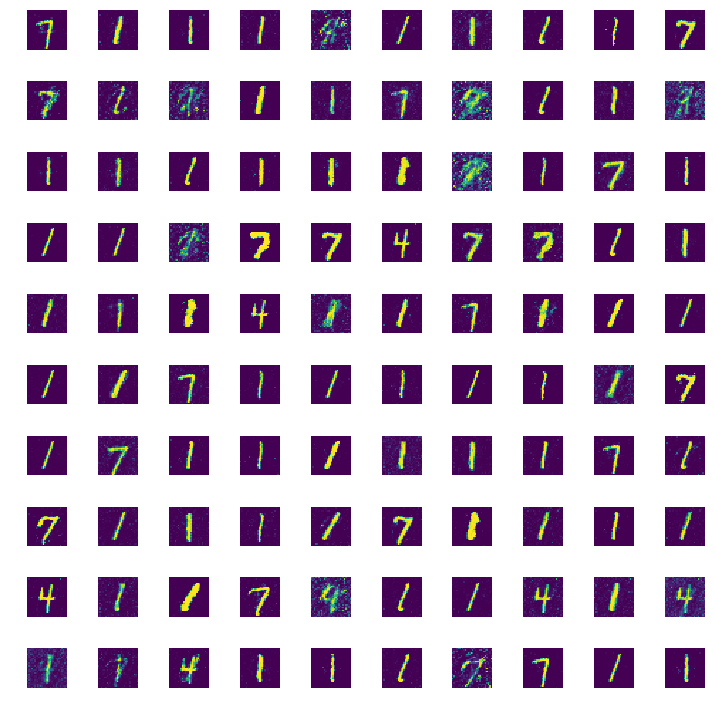

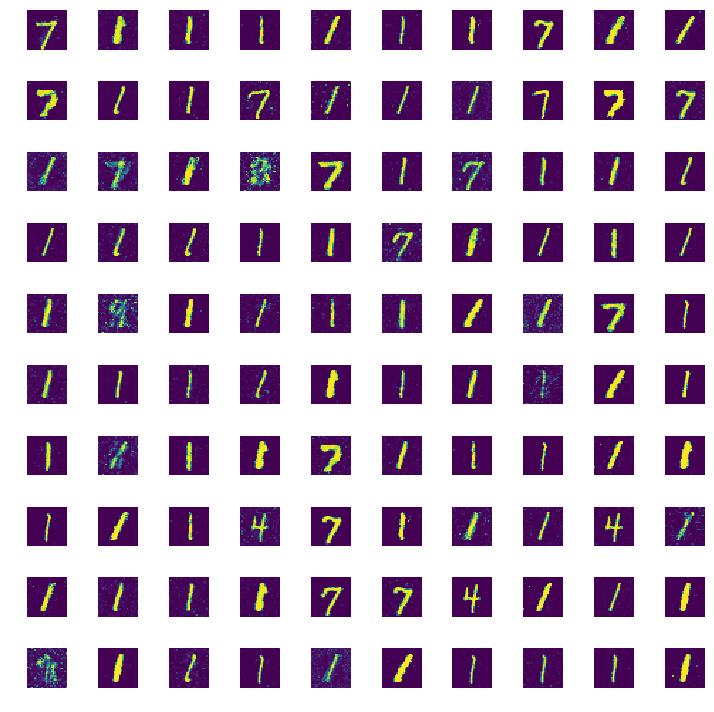

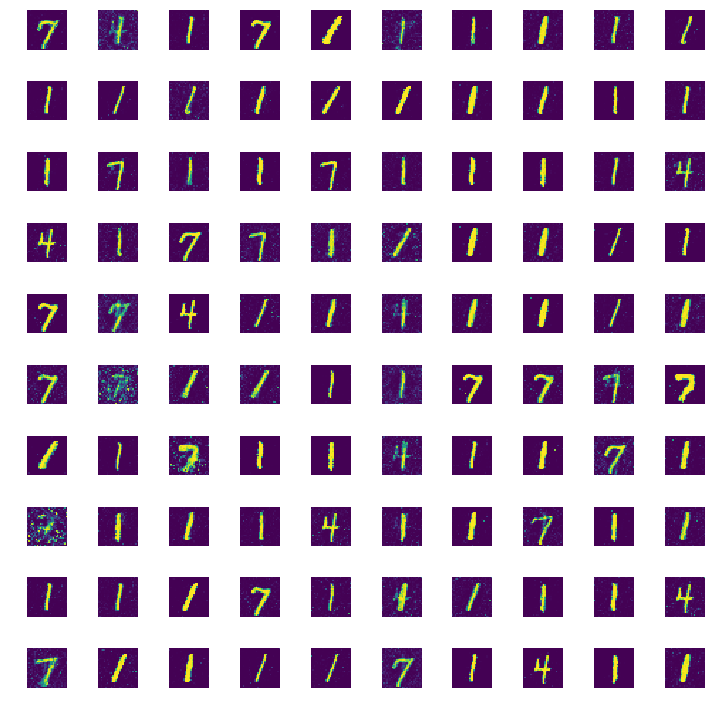

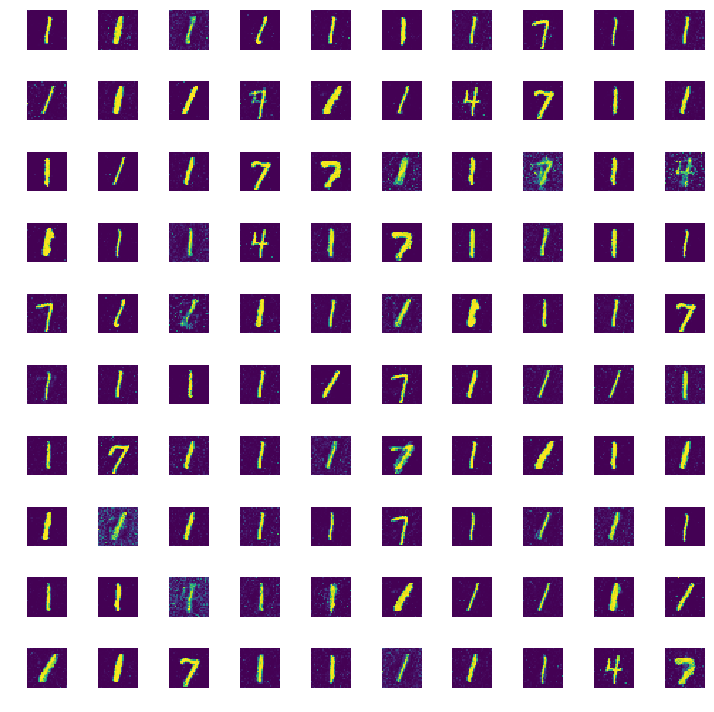

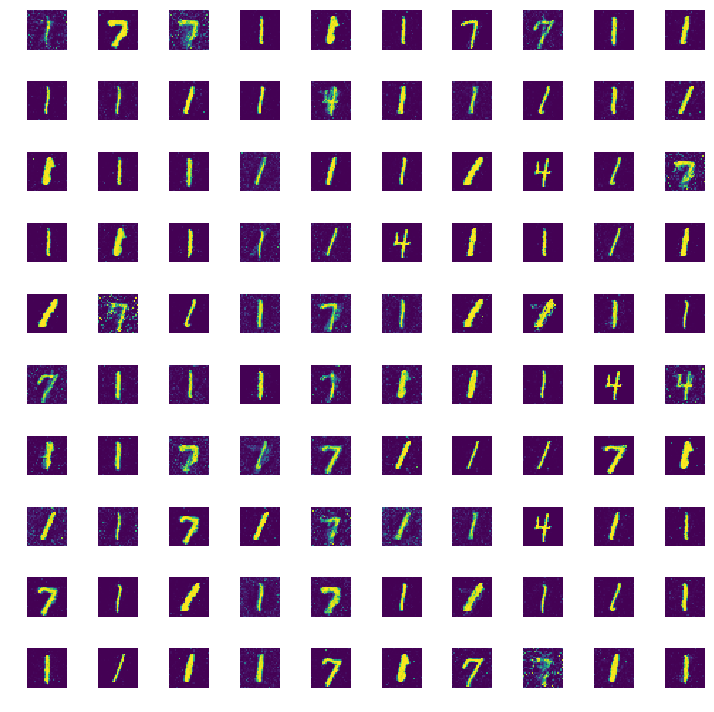

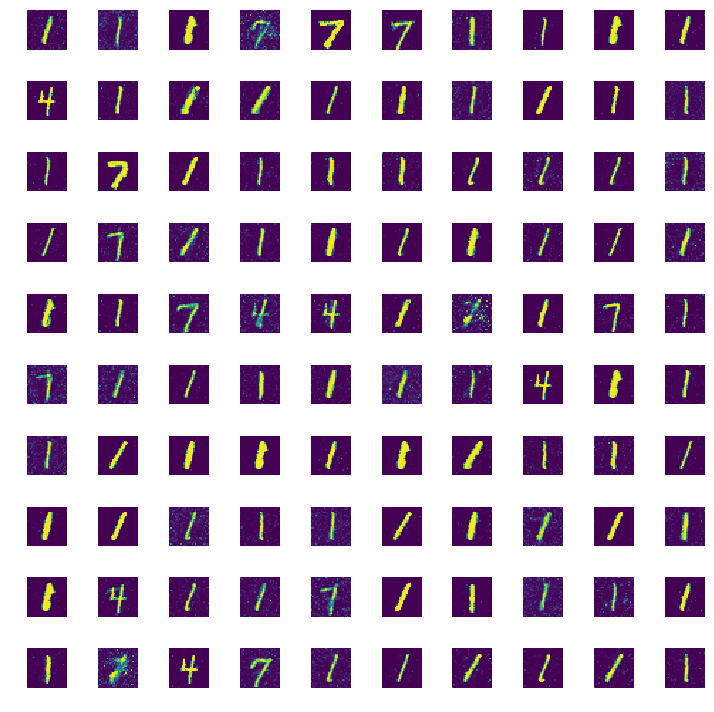

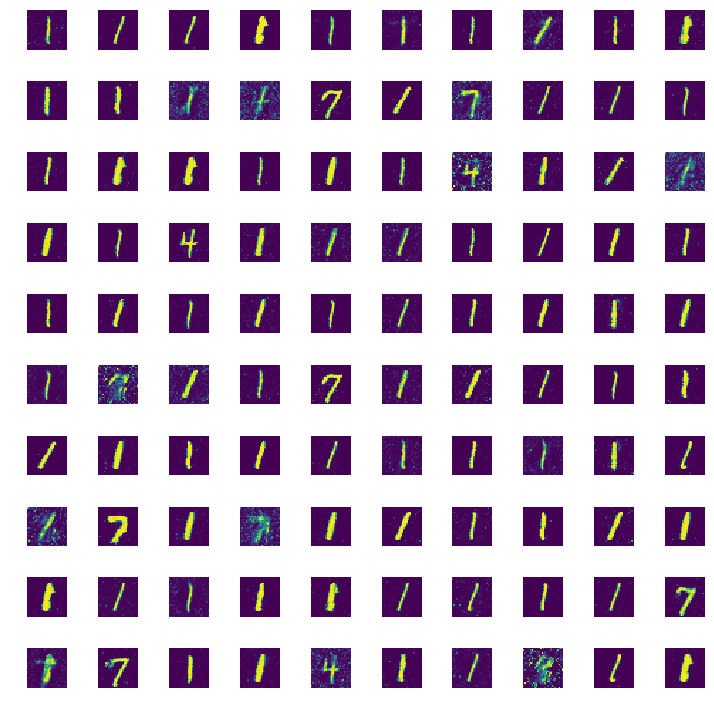

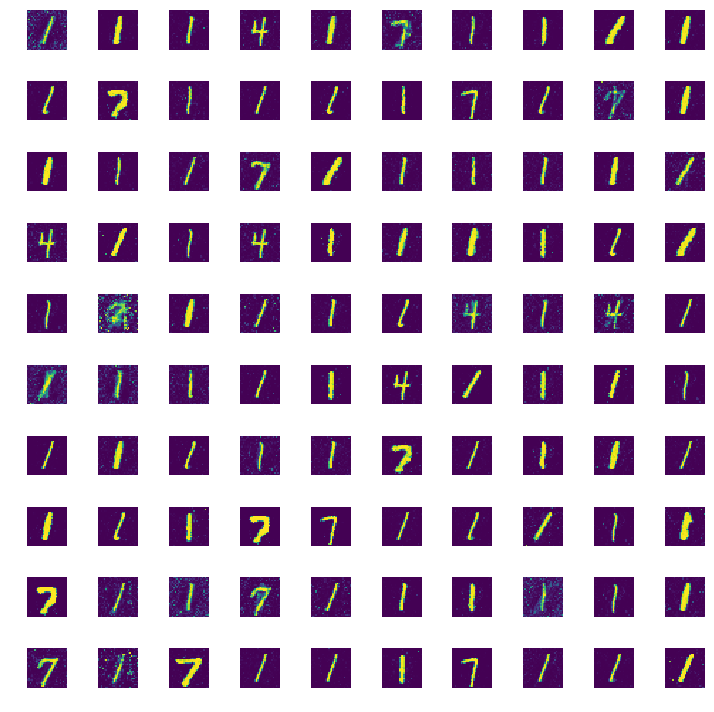

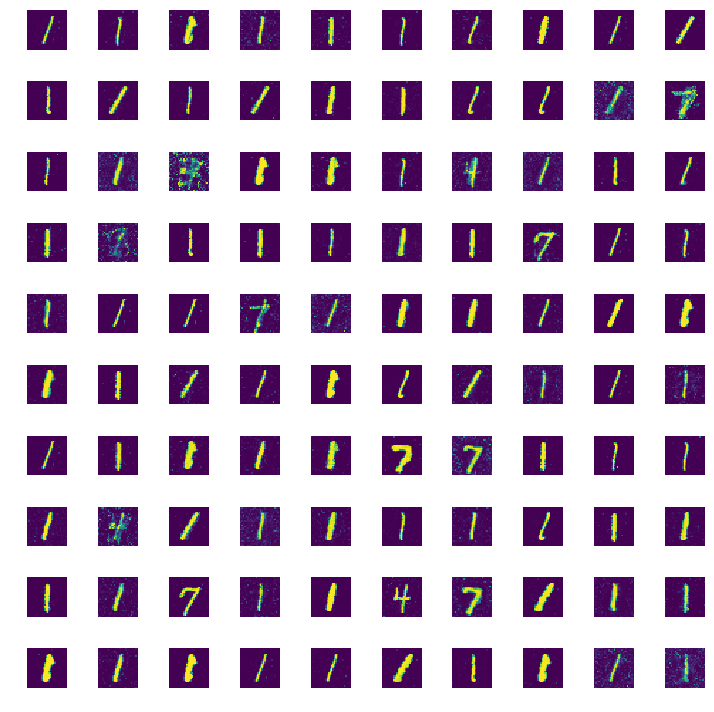

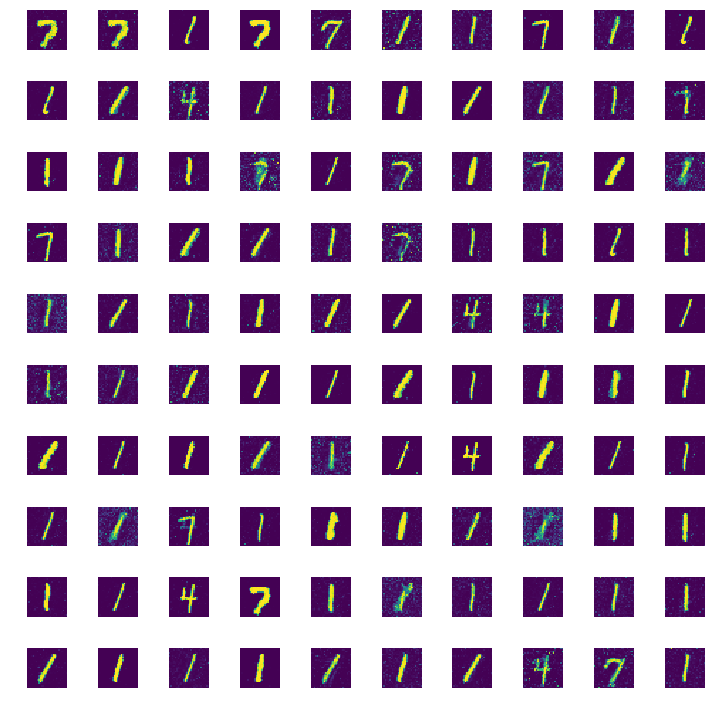

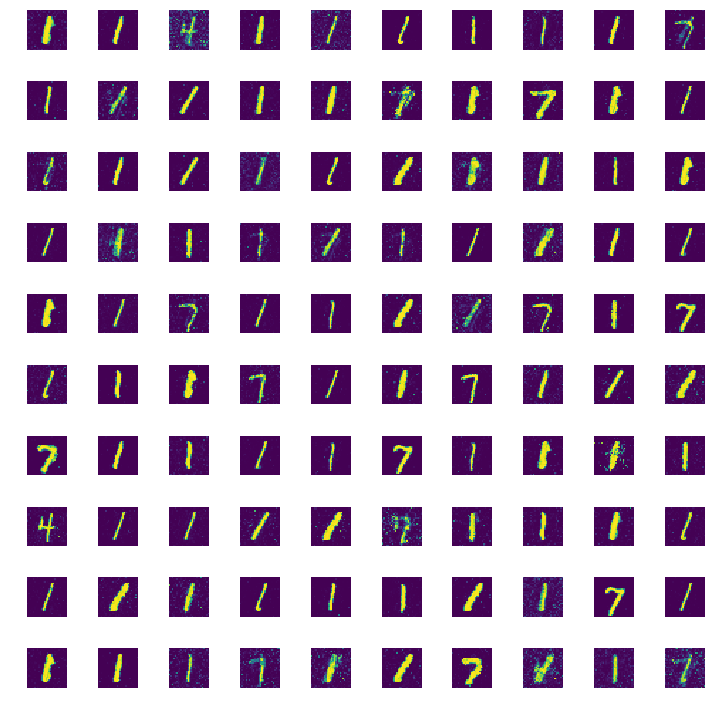

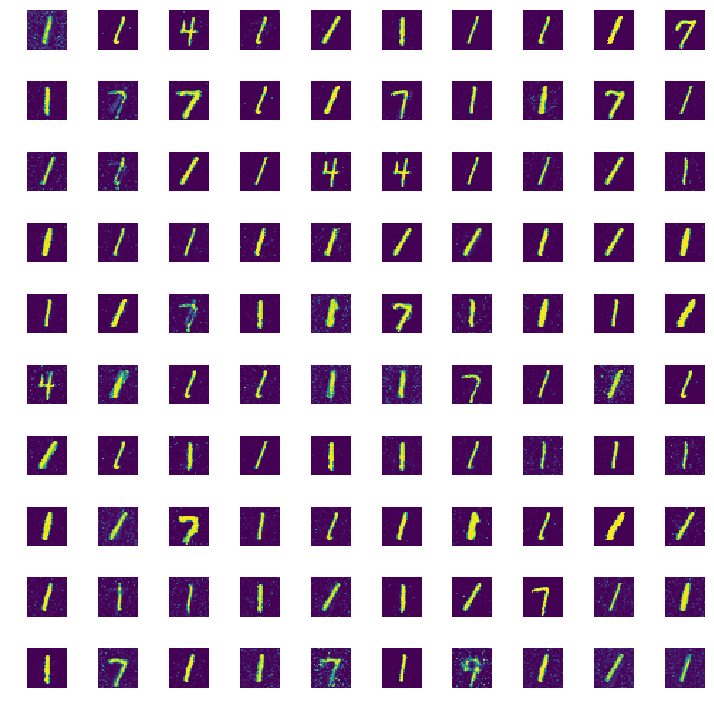

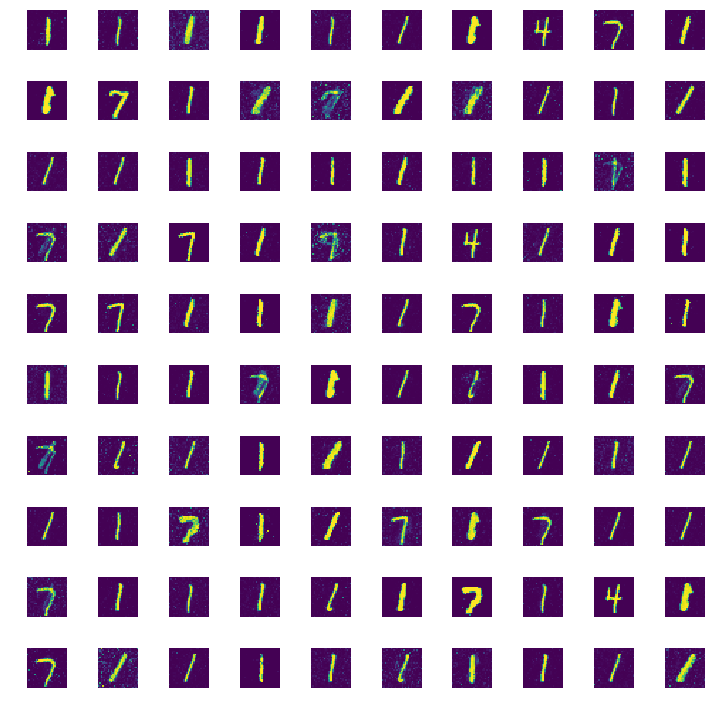

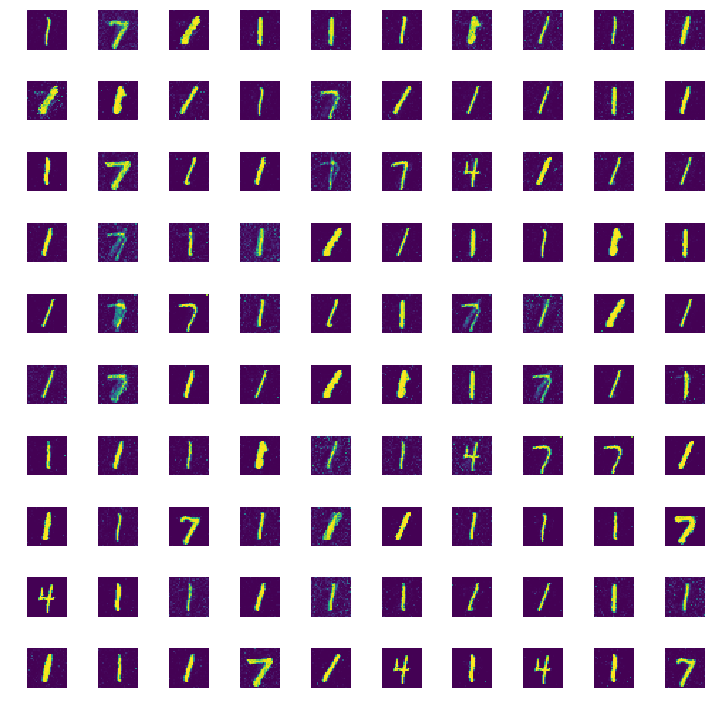

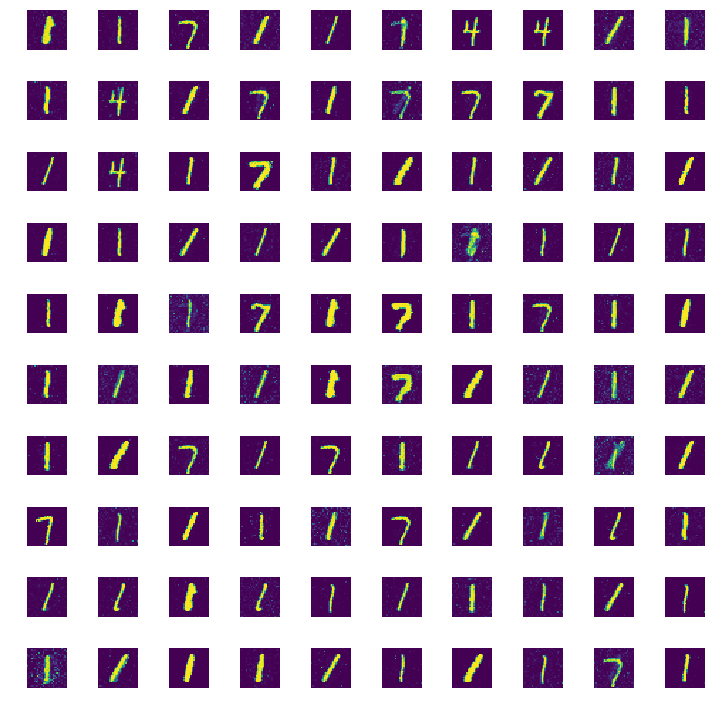

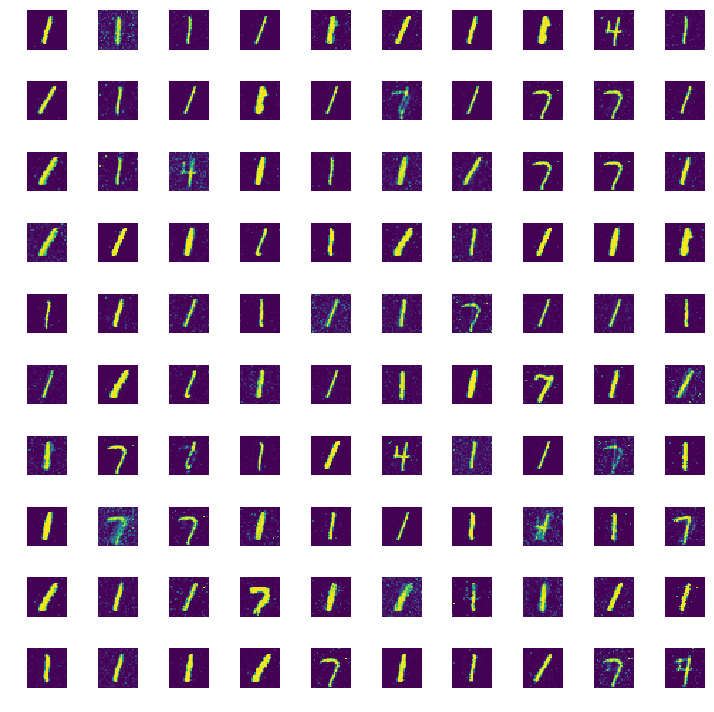

In [5]:
training(400,128)